In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipk
from scipy.optimize import fsolve
import scipy.integrate
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

# Optimal magnetization switching via spin-orbit torque on the surface of a topological insulator

# System description

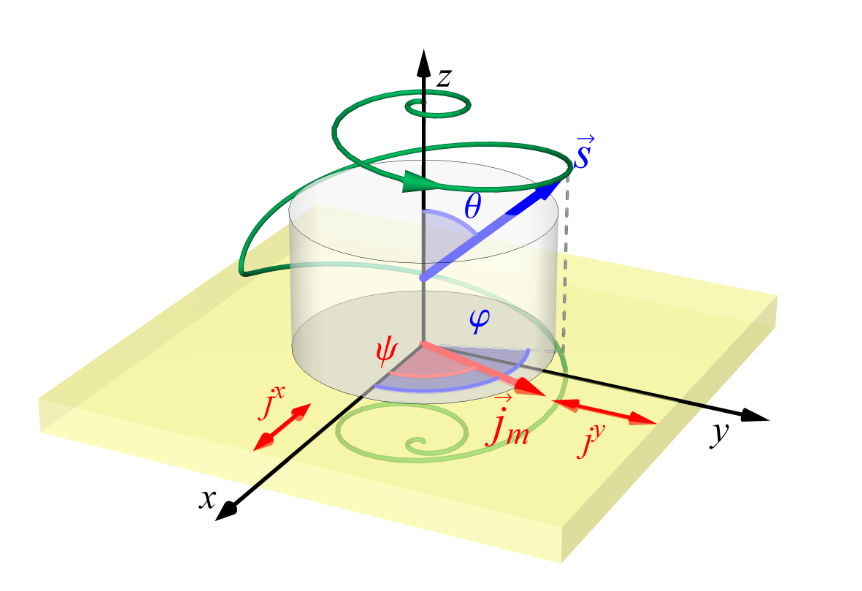

Figure 1. Schematic representation of the system considered with a macrospin, together with the trajectory and the current components.


We consider a monodomain magnetic nanoparticle with easy axis anisotropy. Energy of the system:
$$
    E = -K s_z^2
$$
where $K$ is the anisotropy constant and $s_z$ is the $Z$ component of the normalized magnetic moment.

Dynamics are desribed by Landau-Lifshitz-Gilbert equation with Dirac spin-orbit torques:
$$
    \dot{\vec{s}} = -\gamma\vec{s}\times\vec{b}
	+ \alpha\vec{s}\times\dot{\vec{s}} + \gamma\xi_{F}\vec{s}\times(\vec{j}\times\vec{e}_z) 
	+ \gamma\xi_{D}s_z(\vec{s}\times \vec{j})
$$
where $\gamma$ is the gyromagnetic ratio, $\vec{b} = -\frac{1}{\mu}\frac{d E}{d\vec{s}}$ is the internal magnetic field, $\alpha$ is the Gilbert damping constant, $\xi_F$ and $\xi_D$ are field-like and damping-like torque coefficients respectively, $\vec{j}$ is the current flowing in the $XY$ plane and $\vec{e}_z$ is a unit vector pointing in the $+Z$ direction.

As the relation between the current and overall strength of spin-orbit coupling is trivial, we focus on the ratio between SOT coefficients
$$
\xi_F = \xi\cos\beta,
$$
$$
\xi_D = \xi\sin\beta.
$$
where $\xi$ is the amplitude of the spin-orbit coupling and $\beta$ is a parameter describing the ratio between field-like and damping-like components.

# OCP equation
The Euler-Lagrange equation for the optimal control path can be written as
$$
    \frac{d\theta}{dt} = \pm \frac{1}{\tau_0}\sqrt{\frac{g(\theta) + (1+\alpha^2)c_0}{f(\theta)}}
$$
where:
$$
    f = \frac{(1+\alpha^2)^2}{(1+\alpha^2 \cos^2 \theta)(1-\sin^2 \theta \sin^2 \beta)}
$$

$$
    g = \frac{\alpha^2 \sin^2 (2\theta)}{(1+\alpha^2 \cos^2 \theta)(1-\sin^2 \theta \sin^2 \beta)}
$$

$$
    c_0 = \tau_0^2\left(\left.\frac{d\theta}{dt}\right|_{t=0}\right)^2
$$
Note: $c_0$ is an integration constant that is obtained from its connection to the boundary conditions. Specifically, we calculate it from the following expression for switching time:
$$
    T = 2\tau_0\sqrt{\frac{1+\alpha^2}{c_0 q_+ \cos^2\beta}}\mathcal{K}\left(\frac{q_+ - q_-}{q_+}\right)
$$

Solution to the EL equation is given by
$$
    \theta(t) = \arctan\left(\sqrt{q_-}\mathrm{sc}\left(\sqrt{\frac{c_0 \cos^2\beta}{1+\alpha^2}q_+}\frac{t}{\tau_0},\frac{q_+ - q_-}{q_+}\right)\right)
$$
where
$$
    q_{\pm} = \frac{1}{2}(1+\alpha^2) + \left(\frac{\alpha^2}{2(1+\alpha^2)c_0}+\frac{1}{2}\right)\sec^2\beta \pm \frac{\sqrt{\alpha^4 +c_0^2(1+\alpha^2)^2 ((1+\alpha^2)\cos^2\beta-1)^2 + 2c_0 \alpha^2 (1+\alpha^2)(1+(1+\alpha^2)\cos^2\beta)}}{2(1+\alpha^2)c_0}
$$

Amplitude of the external current has form:
$$
    j = \frac{K}{\mu \xi}\frac{(1+\alpha^2)\tau_0\dot{\theta} + \alpha\sin\theta\cos\theta}{\sqrt{(1+\alpha^2\cos^2\theta)(1-\sin^2\theta\sin^2\beta)}}
$$

$\phi$ as a function of time can be obtained from direct integration of the equation of motion
$$
    \dot{\phi} = \frac{\cos\theta}{\tau_0 \left(1+\alpha^2\cos^2\theta\right)}+\frac{\alpha \dot{\theta}\sin\theta}{1+\alpha^2\cos^2\theta}
$$

Having that, we can calculate the $\psi$ angle as a function of time as well.
$$
    \psi = \phi - \arctan\left(\frac{\left(\alpha\cos\beta+\sin\beta\right)\cos\theta}{\cos\beta-\alpha\sin\beta\cos^2\theta}\right)
$$

In [91]:
# xi=1, mu=1, gamma=1, k=1, time in units of tau_0, as in the paper

# Jacobi amplitude
def am(x, a):
    return ellipj(x, a)[-1]

# elements of the solution
def pre(c, beta, alpha):
    return (c*np.cos(beta)**2)/(1+alpha**2)

def sdel(c, beta, alpha):
    return np.sqrt(alpha**4+c**2 * (1+alpha**2)**2 *((1+alpha**2) *np.cos(beta)**2 - 1)**2 + 2*c*alpha**2 *(1+alpha**2)*(1+(1+alpha**2)*np.cos(beta)**2))

def common(c, beta, alpha):
    return alpha**2 / (2*np.cos(beta)**2 * (1+alpha**2) * c) + (1+alpha**2 + 1/(np.cos(beta)**2))/2

def q1(c, beta, alpha):
    return common(c, beta, alpha) + sdel(c, beta, alpha)/(2*c*(1+alpha**2)*np.cos(beta)**2)

def q2(c, beta, alpha):
    return common(c, beta, alpha) - sdel(c, beta, alpha)/(2*c*(1+alpha**2)*np.cos(beta)**2)

# (includes division by 2)
def arg(t, c, beta, alpha):
    return am(t*np.sqrt(q1(c, beta, alpha)*pre(c, beta, alpha)),(q1(c, beta, alpha)-q2(c, beta, alpha))/q1(c, beta, alpha))
    
# optimal theta(t)
def thetasol(t, c, beta, alpha):
    return np.arctan(np.sqrt(q2(c, beta, alpha))*np.tan(arg(t, c, beta, alpha)))

# time derivative of theta(t)
def dthetasol(t, c, beta, alpha):
    return 2*np.sqrt(pre(c, beta, alpha)*q1(c, beta, alpha)*q2(c, beta, alpha)*(1-(q1(c, beta, alpha)-q2(c, beta, alpha))/q1(c, beta, alpha)*np.sin(arg(t, c, beta, alpha))**2))/(np.cos(arg(t, c, beta, alpha))**2 + q2(c, beta, alpha)*np.sin(arg(t, c, beta, alpha))**2)

# switching time T
def STime(c, beta, alpha):
    return 2*ellipk((q1(c, beta, alpha)-q2(c, beta, alpha))/q1(c, beta, alpha))/(np.sqrt(q1(c, beta, alpha)*pre(c, beta, alpha)))

# Evaluation of 'c' parameter for a given switching time T with c0 as an initial guess
def find_c(T, c0, beta, alpha):
    func = lambda x: (STime(c=x, beta=beta, alpha=alpha)-T)**2
    return fsolve(func, c0)[0]

# Fixing jumps in theta(t). Works on a list of points - not the function itself.
def fix_jumps(theta):
  jumps = theta[1:]-theta[:-1]<-np.pi/2
  delta = np.pi*np.cumsum(jumps.astype(np.int64))
  theta[1:] += delta
  return theta

# time derivative of the phi angle of the optimal control path
def dphi(theta, dtheta, c, beta, alpha):
    return (np.cos(theta)+alpha*np.sin(theta)*dtheta)/(1+alpha**2 * np.cos(theta)**2)

# current angle as a function of phi and theta
def psi(phi, theta, c, beta, alpha):
    return phi - np.arctan2(np.cos(theta)*(alpha*np.cos(beta)+np.sin(beta)),np.cos(beta)-alpha * np.sin(beta)*np.cos(theta)**2)

# time derivative of the current angle
def dpsi(dphi, theta, dtheta, c, beta, alpha):
    return dphi(theta, dtheta, c, beta, alpha) + dtheta*np.sin(theta)*(2*alpha/(1+alpha**2 * np.cos(theta)**2)+np.tan(beta)/(1+np.cos(theta)**2 * np.tan(beta)**2))

# current amplitude as a function of theta and its time derivative
def current_j(theta, dtheta, c, beta, alpha):
    return ((1+alpha**2)*dtheta/2+alpha*np.sin(2*theta)/2)/np.sqrt((1+alpha**2 * np.cos(theta)**2)*(1-np.sin(theta)**2 * np.sin(beta)**2))

# Functions for presenting the results

In [144]:
# Time integration of phi angle
def integrate_phi(ts, dphi_table):
    dphi_table[0] = -dphi_table[-1]
    phi = scipy.integrate.cumtrapz(dphi_table, x=ts, initial=0)
    return phi

# Method showing the results
def show_results(T, dt, beta, alpha):
    #path and current calculations
    c = find_c(T, 1e-7, beta, alpha)
    ts = np.arange(0, T, dt)
    theta = thetasol(ts, c, beta, alpha)
    theta = fix_jumps(theta)
    dtheta = dthetasol(ts, c, beta, alpha)
    dphi_table = dphi(theta, dtheta, c, beta, alpha)
    dpsi_table = dpsi(dphi, theta, dtheta, c, beta, alpha)
    phi = integrate_phi(ts, dphi_table)
    path = [np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)]
    psi_table = psi(phi, theta, c, beta, alpha)
    j = current_j(theta, dtheta, c, beta, alpha)
    current = np.array([j * np.cos(psi_table), j * np.sin(psi_table)])

    # plot preparation
    size = 14
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 16), sharex=True)

    ax1.plot(2*ts, current[0], 'b--', label=r'$j_m^x$')
    ax1.plot(2*ts, current[1], 'r--', label=r'$j_m^y$')
    ax1.plot(2*ts, np.linalg.norm(current, axis=0), 'k', label=r'$j_m$')
    ax1.axhline(0, linestyle='-', linewidth=.5, color='k')
    ax1.set_ylabel(r'Current, $j_m(t)$ [$j_0$]', fontdict={'size': size})
    ax1.set_title(r'OCP for $\beta=${:3.2f}, $\alpha=${:3.2f}'.format(beta, alpha))
    ax1.legend(loc='best', fontsize=11)

    ax2.plot(2*ts, dpsi_table, 'm-')
    ax2.axhline(0, linestyle='-', linewidth=.5, color='k')
    ax2.set_ylabel(r'Frequency, $f$ [$f_r$]', fontdict={'size': size})

    ax3.axhline(0, linestyle='-', linewidth=.5, color='k')
    ax3.plot(2*ts, path[2], 'k--')


    ax3.set_ylabel(r'$s_z$', fontdict={'size': size})
    ax3.set_xlabel(r'Time, $T$ [$\tau_0$]', fontdict={'size': size})


    w = 2*scipy.integrate.trapz(np.linalg.norm(current, axis=0) ** 2, x=ts)
    print('Cost functional:')
    print('\N{GREEK CAPITAL LETTER PHI} = {:.12f} [K/μξ^2γ]'.format(w))

    plt.tight_layout()
    plt.show()

# System's parameters choice

Below you can input $\alpha$, $\beta$ and $T$ (in units of $\tau_0$) values for the optimal pulse visualization. Choose also the value of $dt$.

In [149]:
alpha = 0.1
beta = (np.pi/2)*0
T = 20
dt = 1e-4

# Presentation of results

Cost functional:
Φ = 2.028414794681 [K/μξ^2γ]


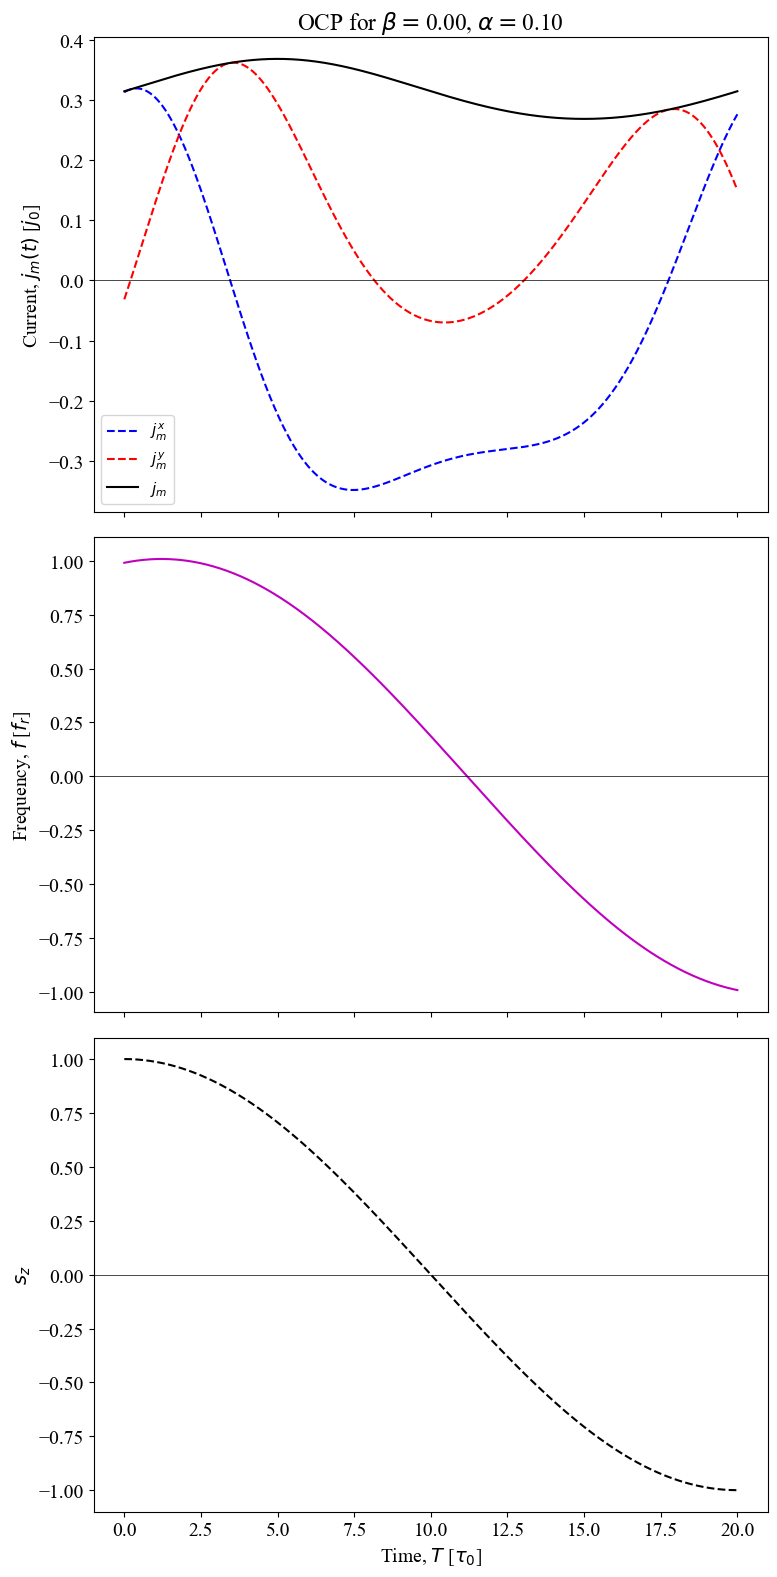

In [150]:
show_results(T*0.5, dt, beta, alpha)

# Optimal switching time ($T_{\textnormal{opt}}$)

The optimal switching time, $T_{\textnormal{opt}}$ is defined as the intersection of the asymptotic behaviors of the cost function $\Phi$ as $T\rightarrow0$ (denoted as $\Phi_0$) and $T\rightarrow\infty$ (denoted as $\Phi_\infty$), which results in a balance between switching speed and energy efficiency.

Formally,

$$
\Phi_{0} = \frac{4(1+\alpha^2)^2\mathcal{K}^2[1-(1+\alpha^2)\cos^2\beta]}{\xi^2 \gamma^2 T}
$$

and 

$$
\Phi_\infty = \frac{4\alpha K (1+\alpha^2) \ln\left[(1+\alpha^2)\cos^2(\beta)\right]}{\gamma\mu\xi^2\left[(1+\alpha^2)\cos^2(\beta)-1\right]}
$$

which, combined as $\Phi_0=\Phi_\infty$ gives

$$
T_{\textnormal{opt}} = \frac{\mu(1+\alpha^2)(\alpha^2-1 +(1+\alpha^2)\cos(2\beta))\mathcal{K}^2[1-(1+\alpha^2)\cos^2\beta]}{2\alpha \gamma K \ln\left((1+\alpha^2)\cos^2\beta\right)},
$$

being naturally a function of $\alpha$, $\beta$ and the system parameters. Below we will explore these values in a phase diagram of $\alpha$ and $\beta$ values, keeping the system parameters and physical constants at unitary value ($\gamma=1$, $K=1$, $\mu=1$).

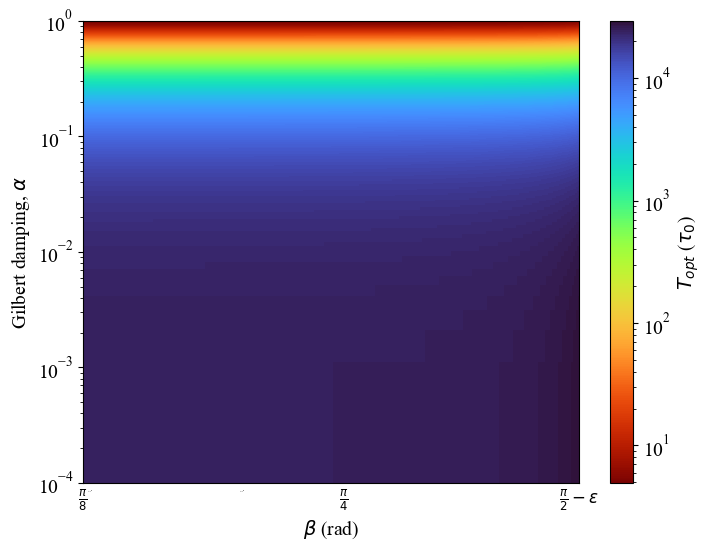

In [8]:
## Definition of the optimal time
def optimal_time(alpha, beta, mu=1, K=1, gamma=1):
    elliptic_modulus = (1 - (1 + alpha**2)*np.cos(beta)**2)
    numerator = mu*(1 + alpha**2)*(alpha**2 - 1 + (1 + alpha**2)*np.cos(2*beta))*(ellipk(elliptic_modulus)**2)
    denominator = 2*alpha*gamma*K*np.log((1 + alpha**2)*(np.cos(beta)**2))
    return numerator/denominator

## Epsilon: deviation from pi/2
epsilon = 1e-1

## Definitions of betas and alphas
alphas = np.logspace(-4, 0, 1000)
betas = np.linspace(np.pi/8, np.pi/2 - epsilon, 1000)

optimal_times = np.zeros((len(alphas), len(betas)))

for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        try:
            optimal_times[i,j] = optimal_time(alpha, beta)
        except ValueError:
            optimal_times[i,j] = np.nan

## Now plot the results

b_v = [np.pi/8, np.pi/4, np.pi/2 - epsilon]

plt.figure(figsize=(8, 6))
norm = mcolors.LogNorm(vmin=np.nanmin(optimal_times[optimal_times > 0]), vmax=np.nanmax(optimal_times))
plt.imshow(optimal_times, extent=[np.min(betas), np.max(betas), np.min(alphas), np.max(alphas)],
           origin='lower', aspect='auto', norm=norm, cmap='turbo_r', interpolation='nearest')
plt.colorbar(label=r'$T_{opt}$ ($\tau_0$)')
plt.xlabel(r'$\beta$ (rad)')
plt.ylabel(r'Gilbert damping, $\alpha$')
plt.yscale('log')
plt.xscale('log')
plt.gca().tick_params(axis='x', which='both', size=0, labelsize=0)

beta_labels = [r"$\frac{\pi}{8}$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}-\epsilon$"]
plt.gca().set_xticks(b_v)
plt.gca().set_xticklabels(beta_labels, fontsize=12)

plt.show()

Here, the value $\epsilon$ is taken as $\epsilon=0.1$ (rad), to facilitate the visualization. Both axes are in logscale.